##### Author: Matthew W. Boyce, PhD, 
##### Email: boyce.matthew@epa.gov

##### Version: 3.0 06-17-2021

##### Description:  
- This script reads the raw data files (.csv or .txt, depending on model) and and a user generated data that lists the metabolites identified in literature and potential markush dhild from those metabolites. The script then aggregates the data into a signle dataFrame, which is used by the GlobalComparison and LocalComparison notebooks to analyze the performance of the in silico prediction tools. The script is scalable and and can be expanded to include more or less metabolite software tools by changing the number of models inthe 'modelList' varible, enuring that the data of additional models are formatted with the correct titles (DTXSID, Metabolite_INCHIKEY, Clean_SMILES, var modelName).

##### Notes: 
- This script uses standard libraries os, pandas, numpy, matplotlib, rdkit, seaborn for data processing and a set of custom functions captured in a py script named model_comp.
- This script pulls data from data directory using the Cookiecutter template from http://drivendata.github.io/cookiecutter-data-science/

##### Potential issues: *None known*

#### Updates:
- Additional processing and analysis performed by Grace Patlewicz, senior PI and corresponding author of the associated manuscript.

#### Revisions following Journal review of manuscript
- Revisions and reprocessing of Toolbox and BioTransformer predictions in light of reviewer comments
- Performed by Grace Patlewicz, senior PI
- Version 4.0 03-Dec-2021


In [2]:
import numpy as np
import os as os
import pandas as pd
import seaborn as sns
import sygma

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import MolsToGridImage

from IPython.core.display import HTML

In [3]:
TOP = os.getcwd().replace('notebooks', '')

In [4]:
raw_dat_dir = TOP + 'data/raw/'
processed_dat_dir = TOP + 'data/processed/'
interim_dat_dir = TOP + 'data/interim/'
figures_dir = TOP + 'reports/figures/'
external_dir = TOP + 'data/external/'

In [5]:
import sys

sys.path.append(TOP + 'src/data/')

from model_comp import *

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Read metabolism prediction filed from the respective in silico tool and preprocess them for substance analysis. 

#### Create a list of the metabolism in silico tools. This can be adjusted depending on the selected tools.

In [7]:
modelList = ['ToolBox_ivt', 'ToolBox_iv','Meteor','BioTransformer3','TIMES_InVivo','TIMES_InVitro', 'SyGMa', 'CTS'] 

#### Import the original csv file containing the ExpoCast substances downloaded from the EPA CompTox Chemicals dashboard
#### Generate two dictionaries for the normal and qsar ready InChI keys to link to DTXSIDs

In [8]:
DSSToxList = pd.read_csv(raw_dat_dir+"CompToxList.csv", header = 0)
DSSToxList = DSSToxList.rename(columns={'INCHIKEY':'Parent_INCHIKEY'})
DSSToxList['QSAR_READY_INCHIKEY'] = SMILES_to_InchiKey(DSSToxList['QSAR_READY_SMILES'],stereoisomer = False)
DSSToxList.to_csv(raw_dat_dir + 'Processed_CompToxList_v1.csv')
Norm_DTXSID_dict = dict(zip(DSSToxList['Parent_INCHIKEY'],DSSToxList['DTXSID']))
QSAR_DTXSID_dict = dict(zip(DSSToxList['QSAR_READY_INCHIKEY'],DSSToxList['DTXSID']))

In [9]:
DSSToxList.head()

,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,Parent_INCHIKEY,SMILES,QSAR_READY_SMILES,QSAR_READY_INCHIKEY
0,DTXSID0044151,DSSTox_Substance_Id,DTXSID0044151,"3,5-Dinitroaniline",618-87-1,MPBZUKLDHPOCLS-UHFFFAOYSA-N,NC1=CC(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O,NC1=CC(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O,MPBZUKLDHPOCLS-UHFFFAOYSA-N
1,DTXSID6025725,DSSTox_Substance_Id,DTXSID6025725,3-Nitroaniline,99-09-2,XJCVRTZCHMZPBD-UHFFFAOYSA-N,NC1=CC(=CC=C1)[N+]([O-])=O,NC1=CC(=CC=C1)[N+]([O-])=O,XJCVRTZCHMZPBD-UHFFFAOYSA-N
2,DTXSID8031077,DSSTox_Substance_Id,DTXSID8031077,Curcumin,458-37-7,VFLDPWHFBUODDF-FCXRPNKRSA-N,COC1=CC(\C=C\C(=O)CC(=O)\C=C\C2=CC=C(O)C(OC)=C...,COC1=CC(C=CC(=O)CC(=O)C=CC2=CC(OC)=C(O)C=C2)=C...,VFLDPWHFBUODDF-UHFFFAOYSA-N
3,DTXSID1025726,DSSTox_Substance_Id,DTXSID1025726,2-Nitroaniline,88-74-4,DPJCXCZTLWNFOH-UHFFFAOYSA-N,NC1=CC=CC=C1[N+]([O-])=O,NC1=CC=CC=C1[N+]([O-])=O,DPJCXCZTLWNFOH-UHFFFAOYSA-N
4,DTXSID4025791,DSSTox_Substance_Id,DTXSID4025791,2-Nitrotoluene,88-72-2,PLAZTCDQAHEYBI-UHFFFAOYSA-N,CC1=CC=CC=C1[N+]([O-])=O,CC1=CC=CC=C1[N+]([O-])=O,PLAZTCDQAHEYBI-UHFFFAOYSA-N


#### Use model_comp.py functions to import and process raw data generated by each of the metabolite in silico tools 

In [10]:
#toolBoxDF = ToolBox_cleanup(raw_dat_dir+'Toolbox_Report.csv', QSAR_DTXSID_dict)
meteorDF = Meteor_cleanup(raw_dat_dir+'Meteor_Report.csv')
#bioTransformerDF = BioTransformer_cleanup(raw_dat_dir+'BioTransformer_Report.csv', Norm_DTXSID_dict)
times_inVivoDF = TIMES_cleanup(raw_dat_dir+'TIMES_010621_iv.csv', 'TIMES_InVivo', header = 0)[['DTXSID','Metabolite_INCHIKEY','Clean_SMILES', 'TIMES_InVivo']]
times_inVitroDF = TIMES_cleanup(raw_dat_dir+'TIMES_010621_ivt.csv', 'TIMES_InVitro')[['DTXSID','Metabolite_INCHIKEY','Clean_SMILES', 'TIMES_InVitro']]
ctsDF = CTS_cleanup(raw_dat_dir+'CTS_All_Report.csv', QSAR_DTXSID_dict)

RDKit WARNING: [14:28:29] WARNING: Charges were rearranged
RDKit WARNING: [14:28:29] WARNING: Charges were rearranged
RDKit WARNING: [14:28:29] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:29] WARNING: Charges were rearranged
RDKit WARNING: [14:28:29] WARNING: Charges were rearranged
RDKit WARNING: [14:28:29] WARNING: Charges were rearranged
RDKit WARNING: [14:28:29] WARNING: Charges were rearranged
RDKit WARNING: [14:28:29] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:29] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:29] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:29] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:29] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:29] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:29] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:29] WARNING: Charges were rearranged
RDKit WARNING: [14:28:29] WARNING: Charges were rearranged
RDKit WARNING: [14:28:29] WARNING: Omitted undef

#### Generate SyGMa metabolites in notebook and using function to return appropriately formatted DF

In [11]:
sygmaDF = pd.read_csv(raw_dat_dir + 'SyGMa_Data.csv')
sygmaDF.shape

(5215, 5)

In [27]:
sygmaDF.head()

,Unnamed: 0,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,SyGMa
0,1,DTXSID0044151,ZXERTWPNZJETAC-UHFFFAOYSA-N,CC(=O)Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1,1
1,2,DTXSID0044151,TTXPIURLJOPGTE-UHFFFAOYSA-N,Nc1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1,1
2,3,DTXSID0044151,QXYMVUZOGFVPGH-UHFFFAOYSA-N,Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O,1
3,4,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
4,5,DTXSID0044151,DJJDJEGEEBJYIT-UHFFFAOYSA-N,CC(=O)Nc1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1,1


In [20]:
if(not os.path.exists(raw_dat_dir + 'SyGMa_Data.csv')):
    sygmaDF = gen_sygma_metabolites_DF(DSSToxList['SMILES'], Norm_DTXSID_dict, pathways = [[sygma.ruleset['phase1'], 2],[sygma.ruleset['phase2'],1]])
    sygmaDF.to_csv(raw_dat_dir + 'SyGMa_Data_100821.csv')
    
sygmaDF = pd.read_csv(raw_dat_dir + 'SyGMa_Data.csv')

In [21]:
sygmaDF.shape

(5215, 5)

In [12]:
bioTransformerDF = pd.read_csv(processed_dat_dir+'BioTransformer3.csv')

In [14]:
bioTransformerDF.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [15]:
toolbox_ivtDF = pd.read_csv(processed_dat_dir+'Toolbox_ivt.csv')
toolbox_ivtDF.drop(['Unnamed: 0'], axis = 1, inplace = True)



In [16]:
toolbox_ivDF = pd.read_csv(processed_dat_dir+'Toolbox_iv.csv')
toolbox_ivDF.drop(['Unnamed: 0'], axis = 1, inplace = True)

#### Import reported metabolites from the file exported by ChemReg and a file relating InChI keys to DTXSIDs

In [19]:
litDF = genLiteratureDF(raw_dat_dir+'ExpocastMetab_CompiledLit.csv', raw_dat_dir+'DTXSID_Markush_Final.csv')

RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitted undefined stereo
RDKit WARNING: [14:28:48] WARNING: Omitt

#### Dataframe generated for each prediction software

In [20]:
meteorDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,Meteor
1,DTXSID0020151,QTBSBXVTEAMEQO-UHFFFAOYSA-N,CC(=O)O,1
2,DTXSID0020151,WVDDGKGOMKODPV-UHFFFAOYSA-N,OCc1ccccc1,1
3,DTXSID0020151,WPYMKLBDIGXBTP-UHFFFAOYSA-N,O=C(O)c1ccccc1,1
4,DTXSID0020151,QIAFMBKCNZACKA-UHFFFAOYSA-N,O=C(O)CNC(=O)c1ccccc1,1
6,DTXSID0020151,BJUXDERNWYKSIQ-UHFFFAOYSA-N,CC(=O)NC(CSCc1ccccc1)C(=O)O,1


In [21]:
bioTransformerDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,BioTransformer
0,DTXSID0044151,QXYMVUZOGFVPGH-UHFFFAOYSA-N,NC1=C(O)C([N+](=O)[O-])=CC([N+](=O)[O-])=C1,1
1,DTXSID0044151,TTXPIURLJOPGTE-UHFFFAOYSA-N,NC1=CC([N+](=O)[O-])=C(O)C([N+](=O)[O-])=C1,1
2,DTXSID0044151,WSIDAANKKVDFNY-UHFFFAOYSA-N,O=[N+]([O-])C1=CC(NO)=CC([N+](=O)[O-])=C1,1
3,DTXSID0044151,OQLXBGXMCLUSAC-UHFFFAOYSA-N,NC1=C(O)C([N+](=O)[O-])=CC([N+](=O)[O-])=C1O,1
4,DTXSID0044151,ZVFXOCHWBWRBDV-UHFFFAOYSA-N,NC1=CC([N+](=O)[O-])=C(O)C([N+](=O)[O-])=C1O,1


In [22]:
times_inVivoDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,TIMES_InVivo
1,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
2,DTXSID0044151,VAWNHKFFVKBVAD-UHFFFAOYSA-N,CC(=O)Nc1cc(N)cc([N+](=O)[O-])c1,1
3,DTXSID0044151,ZXERTWPNZJETAC-UHFFFAOYSA-N,CC(=O)Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1,1
4,DTXSID0044151,PXGZIPCHTTVSHD-UHFFFAOYSA-N,O=C(O)C1OC(Nc2cc([N+](=O)[O-])cc([N+](=O)[O-])...,1
6,DTXSID6025725,WZCQRUWWHSTZEM-UHFFFAOYSA-N,Nc1cccc(N)c1,1


In [23]:
times_inVitroDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,TIMES_InVitro
2,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
3,DTXSID0044151,RPHKINMPYFJSCF-UHFFFAOYSA-N,Nc1cc(N)cc(N)c1,1
4,DTXSID0044151,VUCKZBYGRGKCCQ-UHFFFAOYSA-N,Nc1cc(NO)cc([N+](=O)[O-])c1,1
5,DTXSID0044151,WSIDAANKKVDFNY-UHFFFAOYSA-N,O=[N+]([O-])c1cc(NO)cc([N+](=O)[O-])c1,1
6,DTXSID0044151,KOYVANKECFLLSD-UHFFFAOYSA-N,O=[N+]([O-])c1cc(NOS(=O)(=O)O)cc([N+](=O)[O-])c1,1


In [24]:
toolbox_ivDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,TB_iv
0,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
1,DTXSID6025725,BFMDYVWVKQUBGP-UHFFFAOYSA-N,N=C1C=CC(=O)C(N)=C1,1
2,DTXSID6025725,XIWMTQIUUWJNRP-UHFFFAOYSA-N,Nc1ccc(O)c(N)c1,1
3,DTXSID6025725,WZCQRUWWHSTZEM-UHFFFAOYSA-N,Nc1cccc(N)c1,1
4,DTXSID8031077,WSFSSNUMVMOOMR-UHFFFAOYSA-N,C=O,1


In [34]:
toolbox_ivtDF.head()
toolbox_ivtDF.rename(columns = {'DTXSID_': 'DTXSID'}, inplace = True)

In [39]:
ctsDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,CTS
1,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
2,DTXSID0044151,RPHKINMPYFJSCF-UHFFFAOYSA-N,Nc1cc(N)cc(N)c1,1
3,DTXSID0044151,SUYLOMATYCPVFT-UHFFFAOYSA-N,Nc1cc(N)c(O)c(N)c1,1
4,DTXSID0044151,WFNVGXBEWXBZPL-UHFFFAOYSA-N,Nc1cc(N)cc(O)c1,1
5,DTXSID0044151,VKFBRTZWQOUOSP-UHFFFAOYSA-N,Nc1cc(N)cc(NO)c1,1


In [40]:
litDF.head()

,DTXSID,Metabolite_INCHIKEY,Reported,Metabolite DTXSID,Markush
0,DTXSID1025726,DPJCXCZTLWNFOH-UHFFFAOYSA-N,1,DTXSID1025726,False
1,DTXSID1025726,VEHLRRUCQAPNIT-QUARPLMYSA-N,1,DTXSID101025802,False
2,DTXSID1025726,WHODQVWERNSQEO-UHFFFAOYSA-N,1,DTXSID6020064,False
3,DTXSID1025726,IQXUIDYRTHQTET-UHFFFAOYSA-N,1,DTXSID50209864,False
4,DTXSID1025726,VZLLZDZTQPBHAZ-UHFFFAOYSA-N,1,DTXSID3060669,False


In [28]:
sygmaDF.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [30]:
sygmaDF.head()

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,SyGMa
0,DTXSID0044151,ZXERTWPNZJETAC-UHFFFAOYSA-N,CC(=O)Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1,1
1,DTXSID0044151,TTXPIURLJOPGTE-UHFFFAOYSA-N,Nc1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1,1
2,DTXSID0044151,QXYMVUZOGFVPGH-UHFFFAOYSA-N,Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O,1
3,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
4,DTXSID0044151,DJJDJEGEEBJYIT-UHFFFAOYSA-N,CC(=O)Nc1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1,1


In [32]:
#whos

#### Generate list of the dataframes containing the cleaned data then aggregate the data into a single dataframe: agg_Data
#### Note: In the aggregate data, each software has its own column with a 1 or 0, which indicates that the software predicted or did not predict that metabolite

In [35]:
dfList = [toolbox_ivDF, toolbox_ivtDF, meteorDF, bioTransformerDF,times_inVivoDF, times_inVitroDF, sygmaDF, ctsDF, litDF]
agg_Data = aggregate_DFs(dfList)

agg_Data['Metabolite DTXSID'].replace(0, 'NA', inplace = True)
agg_Data['Markush'].replace(0, False, inplace = True)

agg_Data.sort_values(by='DTXSID')

,DTXSID,Metabolite_INCHIKEY,TB_iv,TB_ivt,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,SyGMa,CTS,Reported,Metabolite DTXSID,Markush
1586,DTXSID0020151,UKPSIRZGSFJNRP-UHFFFAOYSA-N,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NA,False
5424,DTXSID0020151,GNPWZLYNRQMTAP-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
5425,DTXSID0020151,YJEAVKWPGDUAFC-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
5426,DTXSID0020151,JIFDDBBEZMXNFM-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
5427,DTXSID0020151,HNGQRLUIWXZSSX-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821,DTXSID9047251,WFRKCQNMYNPPRB-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
7820,DTXSID9047251,HZCPKDXRBKZWES-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
7819,DTXSID9047251,ASECSWUAAYKVJH-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False
7849,DTXSID9047251,DBQDNRILGFWHSS-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NA,False


In [36]:
agg_Data.DTXSID.nunique()

37

In [37]:
agg_Data.Metabolite_INCHIKEY.nunique()

9129

In [80]:
agg_Data.Reported.sum()

822.0

#### Check aggregated dataframe to see if there are any duplicated pairings of Parent DTXSID - Metabolite InChiKeys

In [38]:
DTXSID_Metab_pairings = list(zip(agg_Data['DTXSID'],agg_Data['Metabolite_INCHIKEY']))
[(i,DTXSID_Metab_pairings.index(DTXSID_Metab_pairings[i]), DTXSID_Metab_pairings[i]) for i in range(len(DTXSID_Metab_pairings)) if not i == DTXSID_Metab_pairings.index(DTXSID_Metab_pairings[i])]

[]

<AxesSubplot:ylabel='DTXSID'>

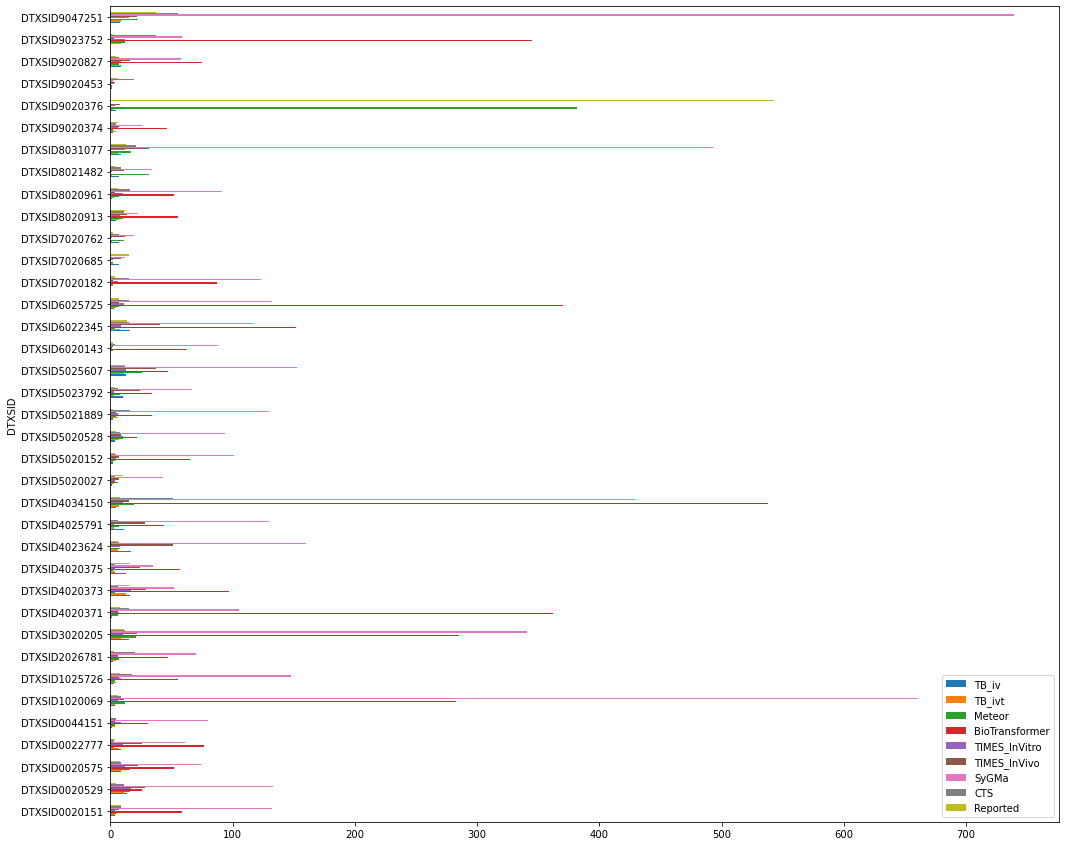

In [40]:
agg_Data.groupby('DTXSID').agg({'TB_iv': 'sum','TB_ivt': 'sum', 'Meteor' :'sum','BioTransformer': 'sum','TIMES_InVitro':'sum','TIMES_InVivo':'sum','SyGMa':'sum','CTS':'sum', 'Reported':'sum'}).plot.barh(figsize = (17,15))

In [41]:
grpby = agg_Data.groupby('DTXSID').agg({'TB_iv': 'sum','TB_ivt': 'sum', 'Meteor' :'sum','BioTransformer': 'sum','TIMES_InVitro':'sum','TIMES_InVivo':'sum','SyGMa':'sum','CTS':'sum', 'Reported':'sum'})
grpby.describe()

,TB_iv,TB_ivt,Meteor,BioTransformer,TIMES_InVitro,TIMES_InVivo,SyGMa,CTS,Reported
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,6.378378,5.243243,19.297297,93.621622,7.648649,15.405405,140.945946,12.756757,22.216216
std,5.198030,3.277918,61.732337,129.567518,4.296098,12.216700,171.918415,12.037916,88.236153
min,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,4.000000,22.000000,4.000000,7.000000,52.000000,6.000000,4.000000
50%,5.000000,5.000000,7.000000,52.000000,8.000000,11.000000,91.000000,9.000000,6.000000
75%,9.000000,7.000000,12.000000,77.000000,10.000000,24.000000,132.000000,15.000000,11.000000
max,17.000000,13.000000,382.000000,538.000000,17.000000,51.000000,739.000000,55.000000,543.000000


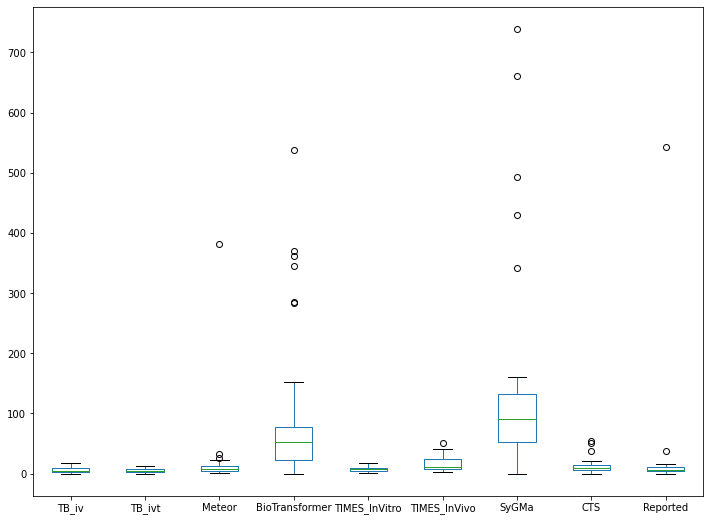

In [42]:
grpby[grpby.columns.tolist()].plot(kind = 'box', figsize = (12,9))

plt.savefig(figures_dir+'BoxPlot_Metabolite_count_031221.png', dpi = 300)

In [43]:
agg_Data.to_csv(processed_dat_dir + 'Cleaned_AggregateData_031221.csv')

In [47]:
agg_Data.sort_values(by = 'DTXSID', ascending = True, inplace = True)

In [48]:
agg_Data.to_csv(processed_dat_dir + 'Cleaned_AggregateData_031221_sorted.csv')

In [60]:
agg_Data[agg_Data['SyGMa'] ==1].shape

(5215, 13)

In [59]:
agg_Data[agg_Data['BioTransformer'] ==1].shape

(3464, 13)

In [61]:
agg_Data[agg_Data['TB_iv'] ==1].shape

(236, 13)

In [62]:
agg_Data[agg_Data['TB_ivt'] ==1].shape

(194, 13)

In [63]:
agg_Data[agg_Data['Meteor'] ==1].shape

(714, 13)

In [64]:
agg_Data[agg_Data['TIMES_InVitro'] ==1].shape

(283, 13)

In [65]:
agg_Data[agg_Data['TIMES_InVivo'] ==1].shape

(570, 13)

In [66]:
agg_Data[agg_Data['CTS'] ==1].shape

(472, 13)

In [76]:
#agg_Data[(agg_Data['DTXSID'] == 'DTXSID5021889') & (agg_Data['BioTransformer'] == 1)]

In [49]:
#agg_Data_orig =pd.read_csv(processed_dat_dir + 'Cleaned_AggregateData.csv')

In [77]:
#agg_Data_orig

In [55]:
#agg_Data_orig.groupby('DTXSID').agg({'ToolBox': 'sum','Meteor' :'sum','BioTransformer': 'sum','TIMES_InVitro':'sum','TIMES_InVivo':'sum','SyGMa':'sum','CTS':'sum', 'Reported':'sum'}).describe()